In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2

# **Visualizing Classes**

In [2]:
train_dir = 'D:/sem 8/CI project/train'
test_dir = 'D:/sem 8/CI project/test'

def Classes_Count( path, name):
    Classes_Dict = {}
    
    for Class in os.listdir(path):
        
        Full_Path = os.path.join(path, Class)
        Classes_Dict[Class] = len(os.listdir(Full_Path))
        
    df = pd.DataFrame(Classes_Dict, index=[name])
    
    return df

Train_Count = Classes_Count(train_dir, 'train').transpose().sort_values(by="train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

In [3]:
pd.concat([Train_Count,Test_Count] , axis=1)

,train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


<Axes: >

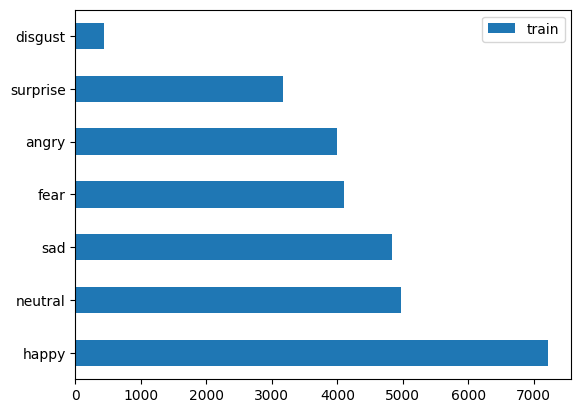

In [4]:
Train_Count.plot(kind='barh')

<Axes: >

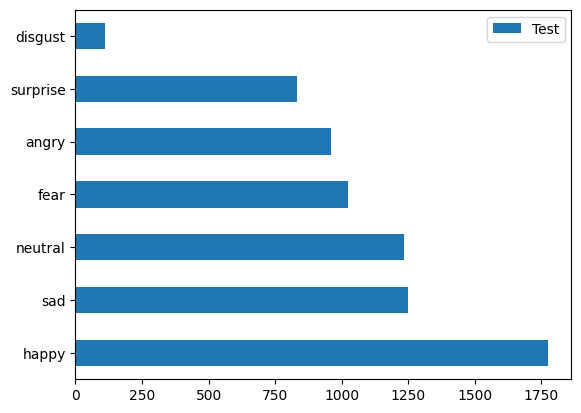

In [5]:
Test_Count.plot(kind='barh')

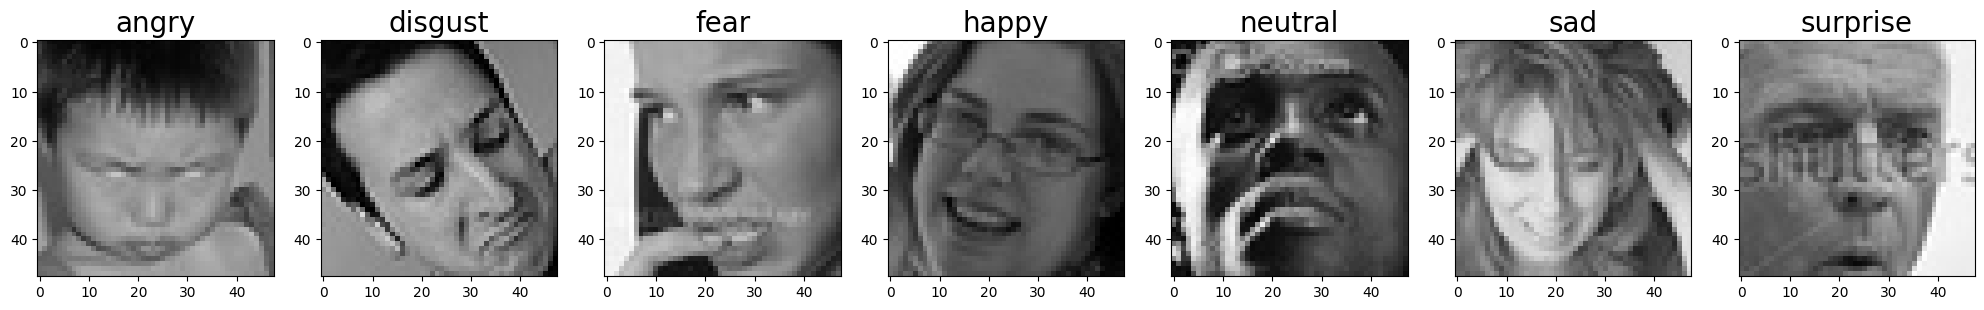

In [6]:
plt.style.use('default')
plt.figure(figsize = (25, 8))
image_count = 1
BASE_URL = 'D:/sem 8/CI project/train'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(os.path.join(BASE_URL, directory))):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(os.path.join(BASE_URL, directory, file))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                plt.imshow(image)
                plt.title(directory, fontsize = 20)

# **Data Preprocessing**

In [7]:
img_shape = 48
batch_size = 64
train_data_path = 'D:/sem 8/CI project/train'
test_data_path = 'D:/sem 8/CI project/test'

In [8]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        # Data Augmentation
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)


test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **Building CNN Model**

In [9]:
def Create_CNN_Model():
    
    model = Sequential()
    
    #CNN1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_shape, img_shape, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    #CNN2
    model.add(Conv2D(64, (3,3), activation='relu', ))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    #CNN3
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    
    #Output
    model.add(Flatten())
    
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(7,activation='softmax'))
    
    
    return model

In [10]:
CNN_Model = Create_CNN_Model()

CNN_Model.summary()

CNN_Model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\Neehar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 9, 9, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 9, 9, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 9, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     6,554,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 7,837,895 (29.90 MB)

 Trainable params: 7,832,519 (29.88 MB)

 Non-trainable params: 5,376 (21.00 KB)

**Specifying Callbacks**

In [11]:
# Create Callback Checkpoint
checkpoint_path = "CNN_Model_Checkpoint.keras"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.000005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [12]:
CNN_history = CNN_Model.fit( train_data , validation_data= test_data , epochs=50, batch_size= batch_size,
                            callbacks=callbacks, steps_per_epoch= steps_per_epoch, validation_steps=validation_steps)

c:\Users\Neehar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 489s 1s/step - accuracy: 0.1819 - loss: 2.2756 - val_accuracy: 0.2518 - val_loss: 1.9052 - learning_rate: 0.0010
Epoch 2/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 333us/step - accuracy: 0.2500 - loss: 1.8784 - val_accuracy: 0.0000e+00 - val_loss: 2.9509 - learning_rate: 0.0010
Epoch 3/50


c:\Users\Neehar\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


448/448 ━━━━━━━━━━━━━━━━━━━━ 417s 931ms/step - accuracy: 0.2652 - loss: 1.7993 - val_accuracy: 0.3657 - val_loss: 1.6164 - learning_rate: 0.0010
Epoch 4/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 131us/step - accuracy: 0.2500 - loss: 1.8269 - val_accuracy: 0.4000 - val_loss: 1.6383 - learning_rate: 0.0010
Epoch 5/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 227s 507ms/step - accuracy: 0.3474 - loss: 1.6566 - val_accuracy: 0.4023 - val_loss: 1.5433 - learning_rate: 0.0010
Epoch 6/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 145us/step - accuracy: 0.3906 - loss: 1.4723 - val_accuracy: 0.8000 - val_loss: 0.9840 - learning_rate: 0.0010
Epoch 7/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 190s 425ms/step - accuracy: 0.4065 - loss: 1.5250 - val_accuracy: 0.4138 - val_loss: 1.5377 - learning_rate: 0.0010
Epoch 8/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 127us/step - accuracy: 0.4688 - loss: 1.4412 - val_accuracy: 1.0000 - val_loss: 0.2831 - learning_rate: 0.0010
Epoch 9/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 319s 712ms/step - accuracy: 0.4575 - loss

# **Evaluating CNN Model**

In [13]:
CNN_Score = CNN_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(CNN_Score[0]))
print("Test Accuracy: {:.2f}%".format(CNN_Score[1] * 100))

113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.2697 - loss: 1.7964
    Test Loss: 1.55488
Test Accuracy: 40.21%


In [14]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()
  
  #plt.tight_layout()

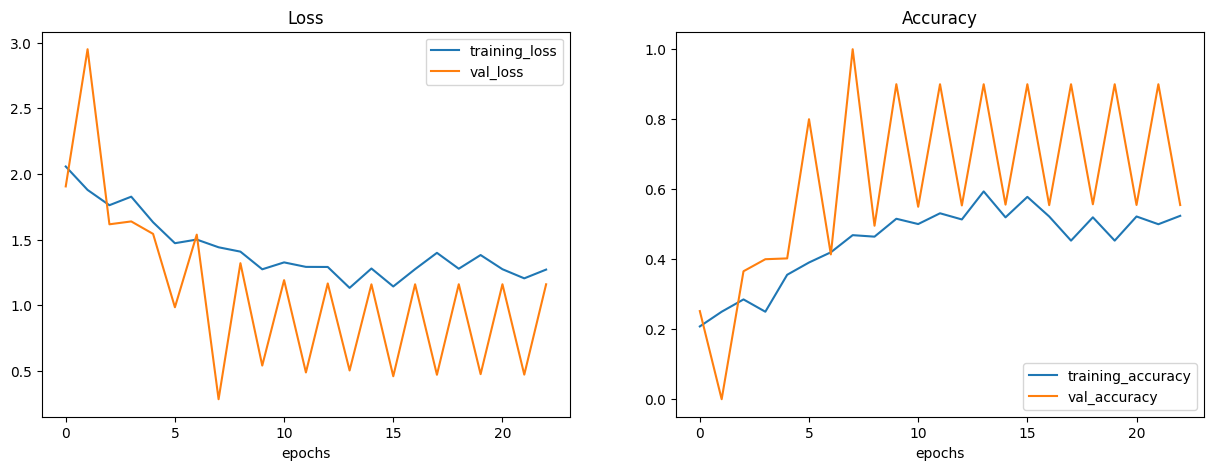

In [15]:
plot_curves(CNN_history)

In [16]:
CNN_Predictions = CNN_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step


In [17]:
test_data.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

Text(0.5, 1.0, 'CNN Confusion Matrix')

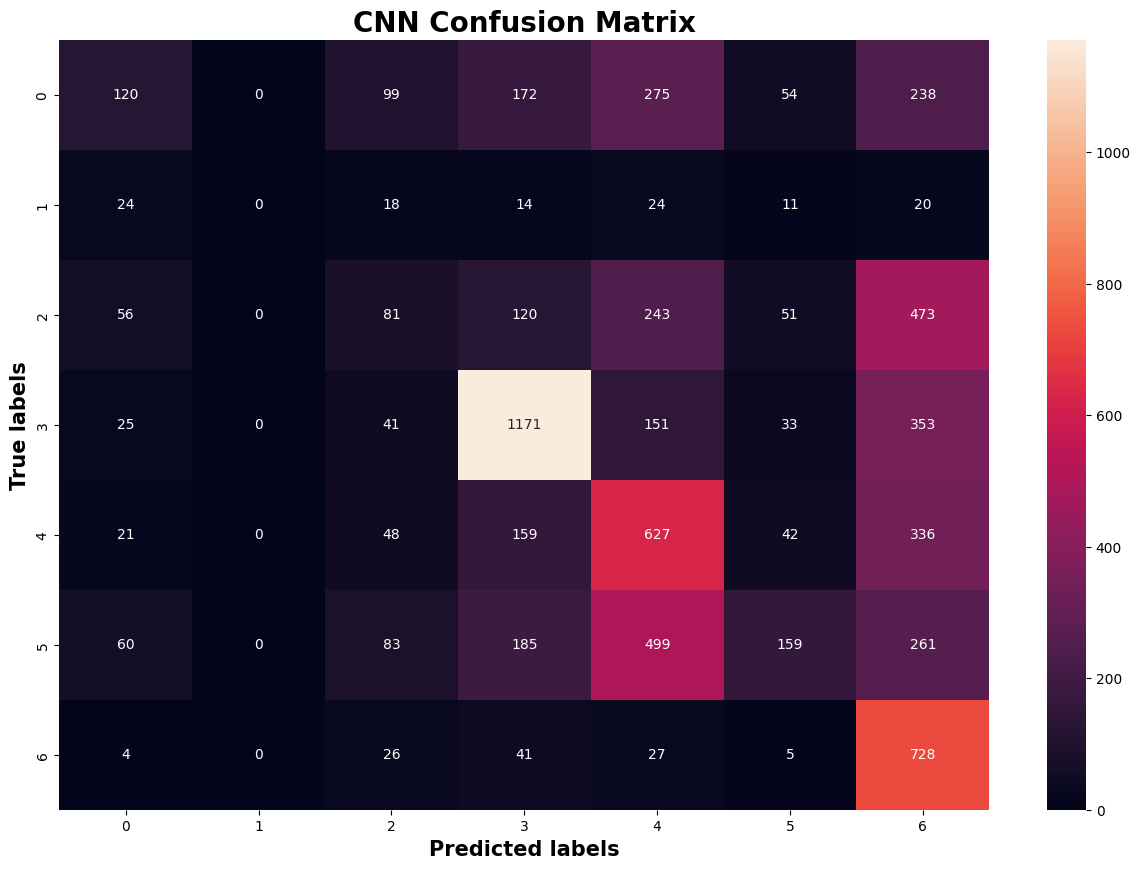

In [18]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, CNN_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

# **ResNet50V2 Model**

In [19]:
# specifing new image shape for resnet
img_shape = 224
batch_size = 64
train_data_path = 'D:/sem 8/CI project/train'
test_data_path = 'D:/sem 8/CI project/test'

In [20]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **Fine-Tuning ResNet50V2**

In [21]:
# 224,224,3
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

#ResNet50V2.summary()

In [22]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [23]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(7,activation='softmax')
                    ])
    return model

In [24]:
ResNet50V2_Model = Create_ResNet50V2_Model()

ResNet50V2_Model.summary()

ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 7, 7, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 7, 7, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,996,295 (114.43 MB)

 Trainable params: 22,779,527 (86.90 MB)

 Non-trainable params: 7,216,768 (27.53 MB)

**Specifying Callbacks**

In [25]:
# Create Callback Checkpoint
checkpoint_path = "ResNet50V2_Model_Checkpoint.keras"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.00005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [26]:
ResNet50V2_history = ResNet50V2_Model.fit(train_data ,validation_data = test_data , epochs=30, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

c:\Users\Neehar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 2501s 6s/step - accuracy: 0.4134 - loss: 1.8016 - val_accuracy: 0.5561 - val_loss: 1.3346 - learning_rate: 0.0010
Epoch 2/30
  1/448 ━━━━━━━━━━━━━━━━━━━━ 28:40 4s/step - accuracy: 0.6094 - loss: 1.1254

c:\Users\Neehar\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


448/448 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6094 - loss: 1.1254 - val_accuracy: 0.9000 - val_loss: 0.4428 - learning_rate: 0.0010
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 1969s 4s/step - accuracy: 0.5571 - loss: 1.2482 - val_accuracy: 0.6046 - val_loss: 1.5161 - learning_rate: 0.0010
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5781 - loss: 1.2443 - val_accuracy: 1.0000 - val_loss: 0.1136 - learning_rate: 0.0010
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 1986s 4s/step - accuracy: 0.5469 - loss: 1.2596 - val_accuracy: 0.5604 - val_loss: 1.1651 - learning_rate: 0.0010
Epoch 6/30
  1/448 ━━━━━━━━━━━━━━━━━━━━ 25:48 3s/step - accuracy: 0.5000 - loss: 1.2824
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5000 - loss: 1.2824 - val_accuracy: 0.9000 - val_loss: 0.4006 - learning_rate: 0.0010
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 1858s 4s/step - accuracy: 0.6074 - loss: 1.0798 - val

# **Evaluating ResNet50V2**

In [27]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

113/113 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.5442 - loss: 1.6963
    Test Loss: 1.62833
Test Accuracy: 59.95%


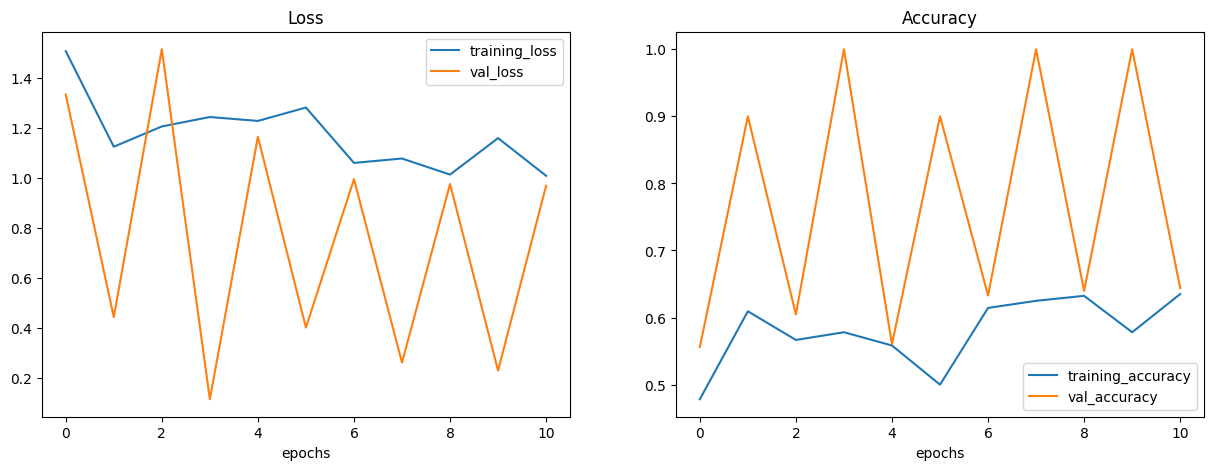

In [28]:
plot_curves(ResNet50V2_history)

In [29]:
ResNet50V2_Predictions = ResNet50V2_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step


Text(0.5, 1.0, 'ResNet50V2 Confusion Matrix')

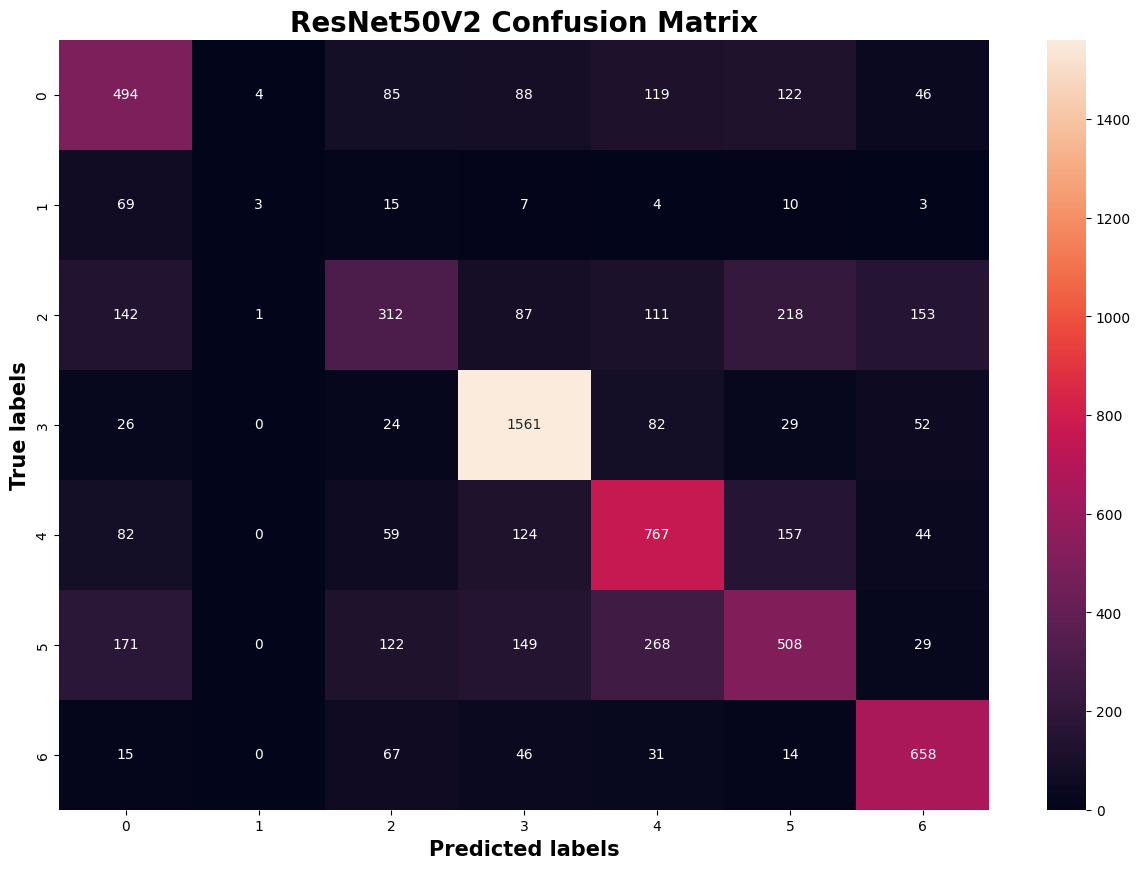

In [30]:
fig , ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, ResNet50V2_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('ResNet50V2 Confusion Matrix', fontsize=20, fontweight='bold')

# **Visualizing Predictions**

In [38]:
Emotion_Classes = ['Angry', 
                  'Disgust', 
                  'Fear', 
                  'Happy', 
                  'Neutral', 
                  'Sad', 
                  'Surprise']

In [39]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


**CNN Predictions**

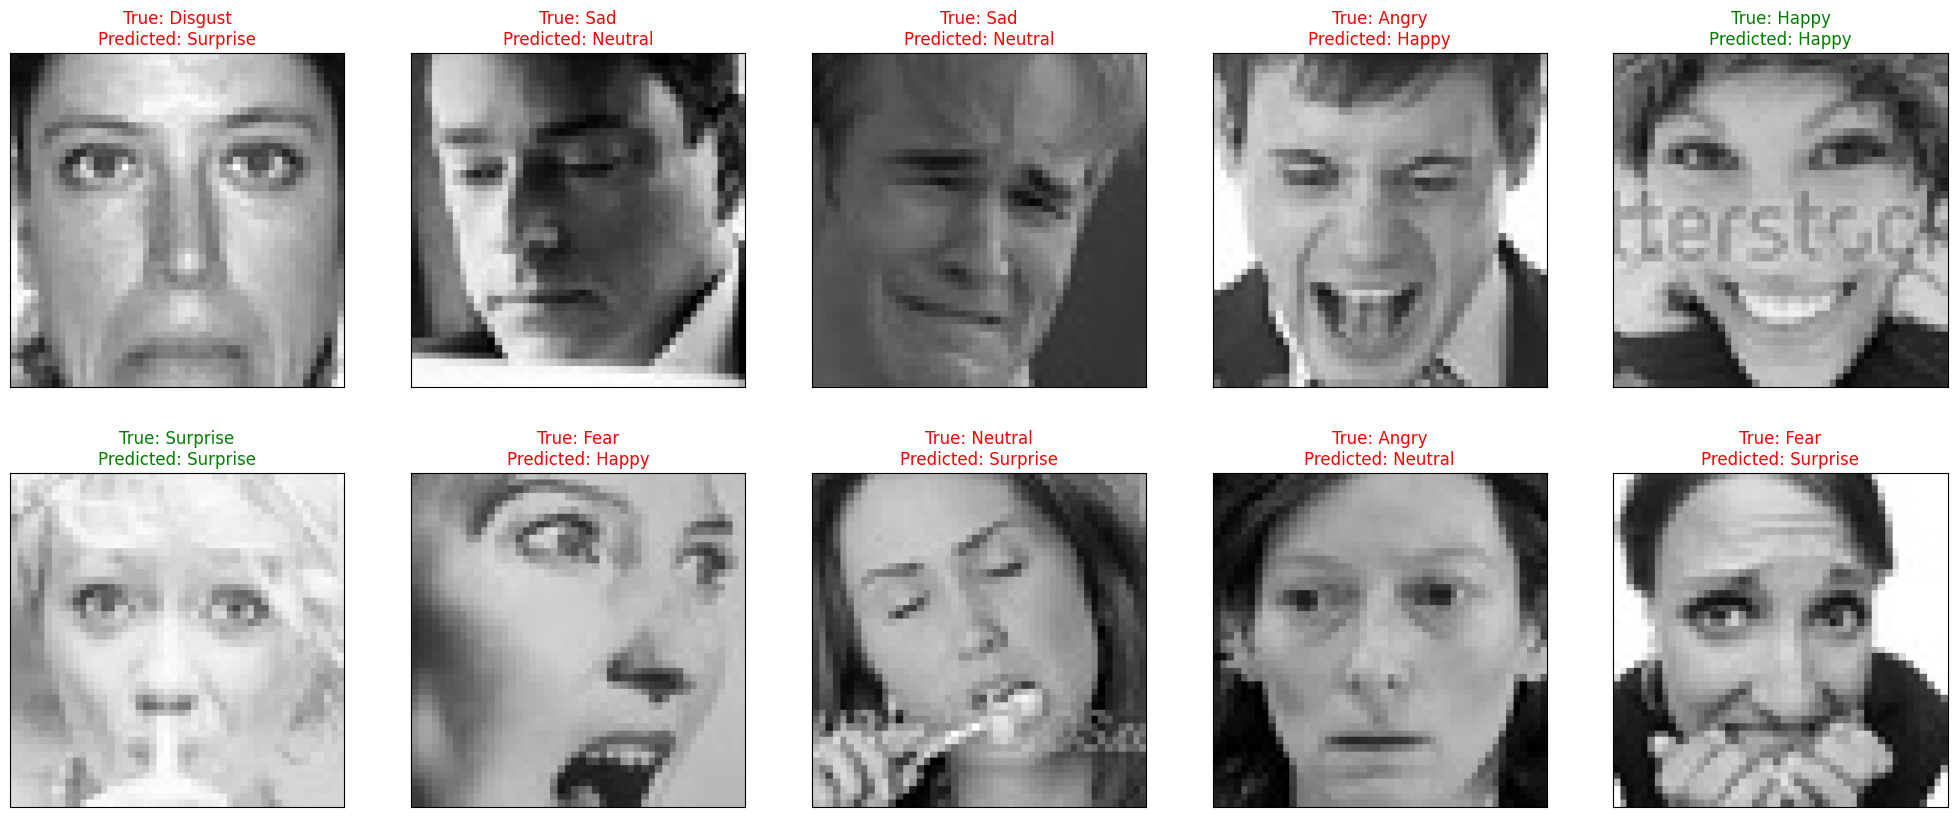

<Figure size 640x480 with 0 Axes>

In [41]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    # Resize and preprocess the image to match the input shape of the CNN_Model
    Resized_Img = tf.image.resize(Random_Img, (48, 48))  # Resize to match CNN_Model input shape
    Resized_Img = tf.expand_dims(Resized_Img, axis=0)  # Add batch dimension
    Model_Prediction = np.argmax(CNN_Model.predict(Resized_Img, verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

**ResNet50V2 Predictions**

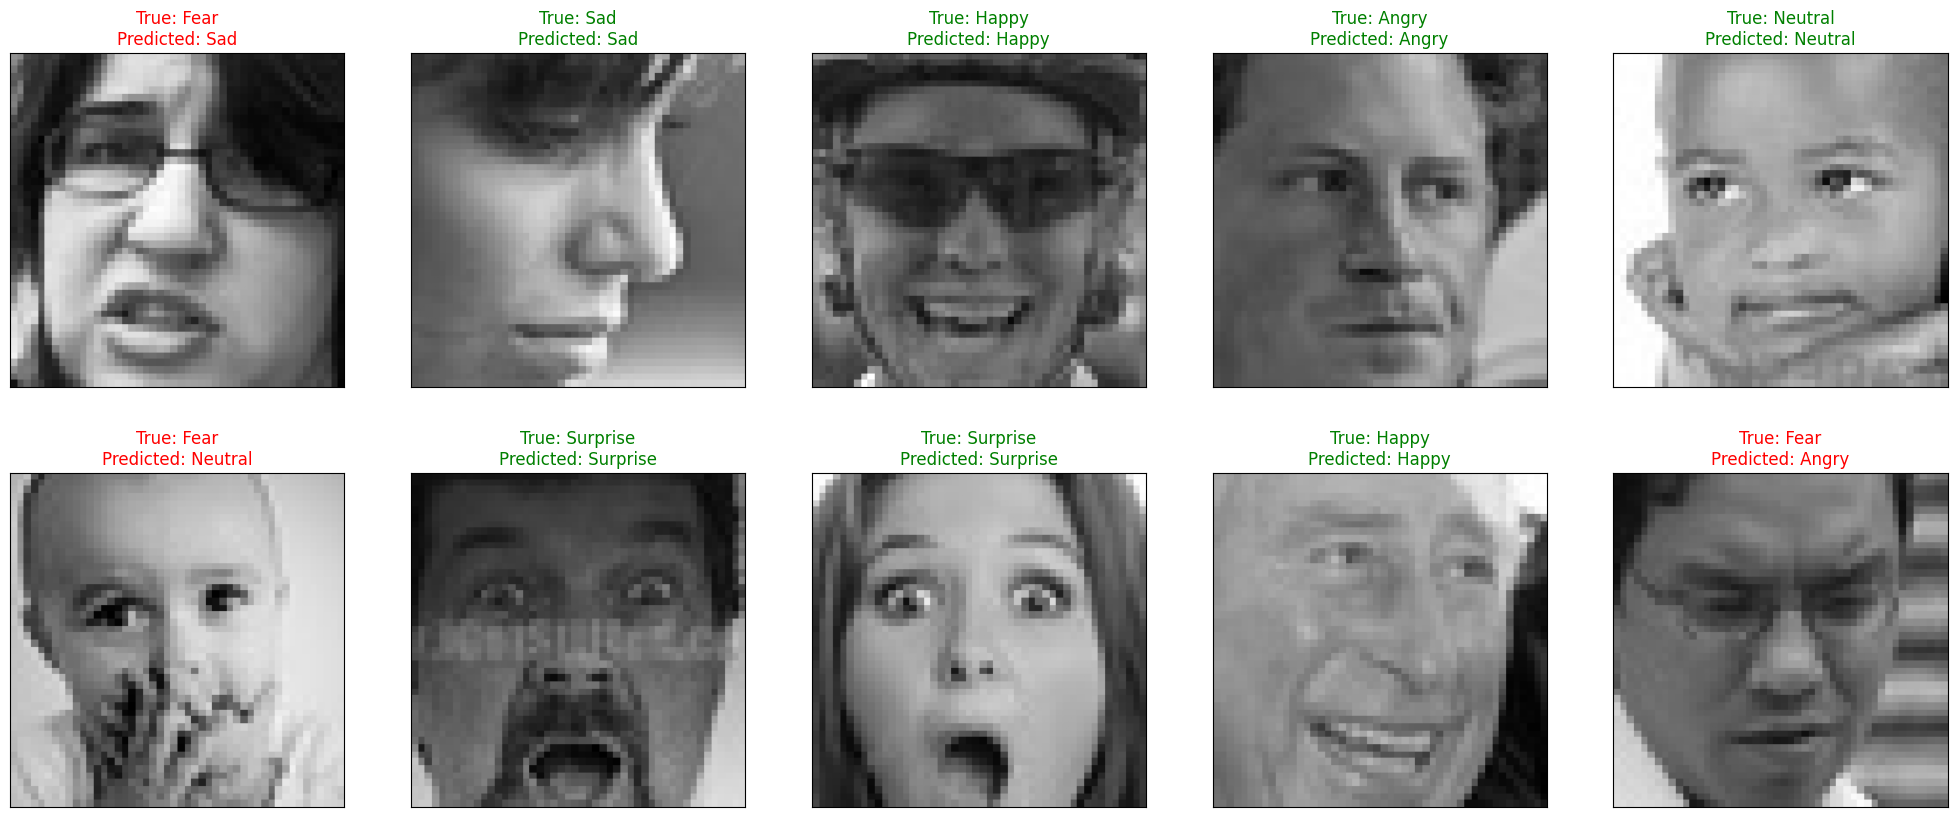

<Figure size 640x480 with 0 Axes>

In [42]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(ResNet50V2_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

# **Music Player**

In [43]:
Music_Player = pd.read_csv("D:/sem 8/CI project/data_moods.csv")
Music_Player = Music_Player[['name','artist','mood','popularity']]
Music_Player.head()

,name,artist,mood,popularity
0,1999,Prince,Happy,68
1,23,Blonde Redhead,Sad,43
2,9 Crimes,Damien Rice,Sad,60
3,99 Luftballons,Nena,Happy,2
4,A Boy Brushed Red Living In Black And White,Underoath,Energetic,60


In [44]:
Music_Player["mood"].value_counts()

mood
Sad          197
Calm         195
Energetic    154
Happy        140
Name: count, dtype: int64

In [45]:
Music_Player["popularity"].value_counts()

popularity
0     92
51    23
52    22
50    21
55    21
      ..
80     1
2      1
14     1
15     1
88     1
Name: count, Length: 83, dtype: int64

In [46]:
Play = Music_Player[Music_Player['mood'] =='Calm' ]
Play = Play.sort_values(by="popularity", ascending=False)
Play = Play[:5].reset_index(drop=True)
display(Play)

,name,artist,mood,popularity
0,Lost,Annelie,Calm,64
1,Curiosity,Beau Projet,Calm,60
2,Escaping Time,Benjamin Martins,Calm,60
3,Just Look at You,369,Calm,59
4,Vague,Amaranth Cove,Calm,59


In [47]:
# Making Songs Recommendations Based on Predicted Class
def Recommend_Songs(pred_class):
    
    if( pred_class=='Disgust' ):

        Play = Music_Player[Music_Player['mood'] =='Sad' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Happy' or pred_class=='Sad' ):

        Play = Music_Player[Music_Player['mood'] =='Happy' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Fear' or pred_class=='Angry' ):

        Play = Music_Player[Music_Player['mood'] =='Calm' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

    if( pred_class=='Surprise' or pred_class=='Neutral' ):

        Play = Music_Player[Music_Player['mood'] =='Energetic' ]
        Play = Play.sort_values(by="popularity", ascending=False)
        Play = Play[:5].reset_index(drop=True)
        display(Play)

# **Predicting New Images**

**Downloading OpenCV haarcascade frontalface Detection**

In [55]:
import requests

# Download the haarcascade file
url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"
response = requests.get(url)
with open("haarcascade_frontalface_default.xml", "wb") as file:
	file.write(response.content)

# Load the cascade classifier
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

In [56]:
def load_and_prep_image(filename, img_shape = 224):

    img = cv2.imread(filename)

    GrayImg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    faces = faceCascade.detectMultiScale(GrayImg, 1.1, 4)
    
    for x,y,w,h in faces:
        
        roi_GrayImg = GrayImg[ y: y + h , x: x + w ]
        roi_Img = img[ y: y + h , x: x + w ]
        
        cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2)
        
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        
        faces = faceCascade.detectMultiScale(roi_Img, 1.1, 4)
        
        if len(faces) == 0:
            print("No Faces Detected")
        else:
            for (ex, ey, ew, eh) in faces:
                img = roi_Img[ ey: ey+eh , ex: ex+ew ]
    
    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    RGBImg= cv2.resize(RGBImg,(img_shape,img_shape))

    RGBImg = RGBImg/255.

    return RGBImg

In [67]:
def pred_and_plot(filename, class_names):

    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = ResNet50V2_Model.predict(np.expand_dims(img, axis=0))

    # Get the predicted class
    pred_class = class_names[pred.argmax()]

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);
    
    Recommend_Songs(pred_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


,name,artist,mood,popularity
0,Pumped Up Kicks,Foster The People,Happy,84
1,Africa,TOTO,Happy,84
2,Take on Me,a-ha,Happy,84
3,Highway to Hell,AC/DC,Happy,83
4,Here Comes The Sun - Remastered 2009,The Beatles,Happy,83


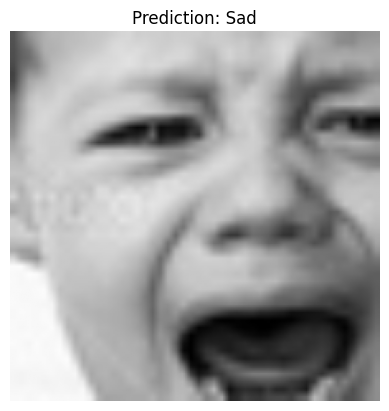

In [85]:
pred_and_plot("D:/sem 8/CI project/test/sad/PrivateTest_3594279.jpg", Emotion_Classes) # with CNN

#"D:\sem 8\CI project\test\sad\PrivateTest_3594279.jpg"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


,name,artist,mood,popularity
0,Pumped Up Kicks,Foster The People,Happy,84
1,Africa,TOTO,Happy,84
2,Take on Me,a-ha,Happy,84
3,Highway to Hell,AC/DC,Happy,83
4,Here Comes The Sun - Remastered 2009,The Beatles,Happy,83


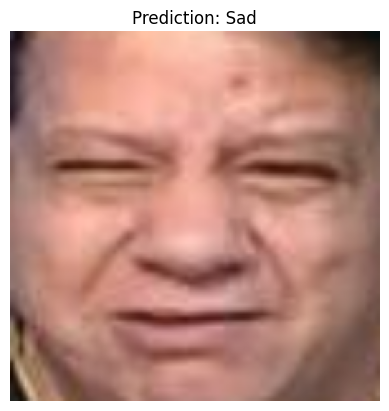

In [86]:
pred_and_plot("D:/sem 8/CI project/EEY3RFFWwAAc-qm.jpg", Emotion_Classes) # with CNN

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


,name,artist,mood,popularity
0,Lost,Annelie,Calm,64
1,Curiosity,Beau Projet,Calm,60
2,Escaping Time,Benjamin Martins,Calm,60
3,Just Look at You,369,Calm,59
4,Vague,Amaranth Cove,Calm,59


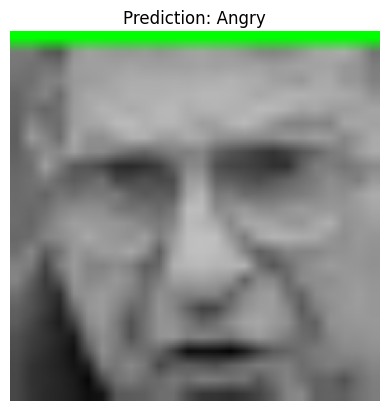

In [87]:
pred_and_plot("D:/sem 8/CI project/test/angry/PrivateTest_22126718.jpg", Emotion_Classes) # with ResNet50V2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


,name,artist,mood,popularity
0,Chop Suey!,System Of A Down,Energetic,79
1,Killing In The Name,Rage Against The Machine,Energetic,78
2,Dani California,Red Hot Chili Peppers,Energetic,77
3,Duality,Slipknot,Energetic,76
4,Uprising,Muse,Energetic,75


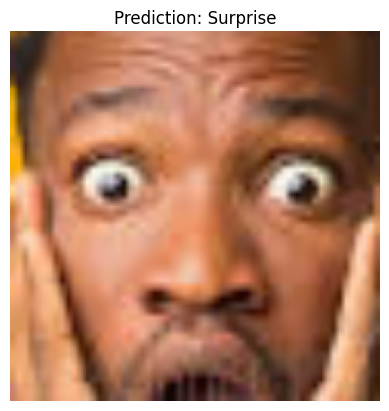

In [89]:
pred_and_plot( "D:/sem 8/CI project/download (3).jpg" , Emotion_Classes) # with ResNet50V2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


,name,artist,mood,popularity
0,Chop Suey!,System Of A Down,Energetic,79
1,Killing In The Name,Rage Against The Machine,Energetic,78
2,Dani California,Red Hot Chili Peppers,Energetic,77
3,Duality,Slipknot,Energetic,76
4,Uprising,Muse,Energetic,75


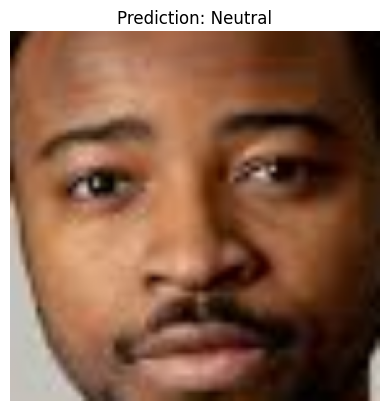

In [90]:
pred_and_plot( "D:/sem 8/CI project/download (4).jpg" , Emotion_Classes) # with ResNet50V2

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


,name,artist,mood,popularity
0,Lost,Annelie,Calm,64
1,Curiosity,Beau Projet,Calm,60
2,Escaping Time,Benjamin Martins,Calm,60
3,Just Look at You,369,Calm,59
4,Vague,Amaranth Cove,Calm,59


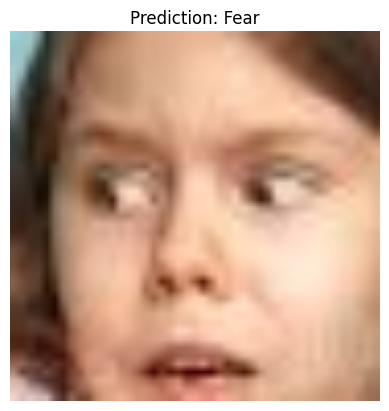

In [92]:
pred_and_plot( "D:/sem 8/CI project/download.jpg" , Emotion_Classes) # with ResNet50V2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


,name,artist,mood,popularity
0,Chop Suey!,System Of A Down,Energetic,79
1,Killing In The Name,Rage Against The Machine,Energetic,78
2,Dani California,Red Hot Chili Peppers,Energetic,77
3,Duality,Slipknot,Energetic,76
4,Uprising,Muse,Energetic,75


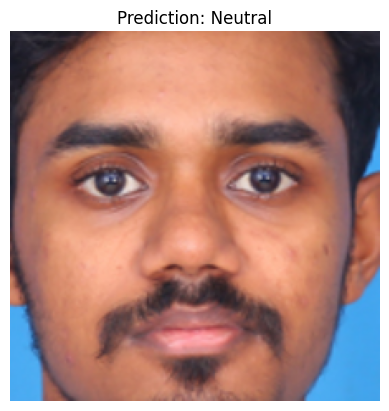

In [96]:
pred_and_plot( "D:/documents/passport size photo(1).jpg" , Emotion_Classes) # with ResNet50V2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


,name,artist,mood,popularity
0,Pumped Up Kicks,Foster The People,Happy,84
1,Africa,TOTO,Happy,84
2,Take on Me,a-ha,Happy,84
3,Highway to Hell,AC/DC,Happy,83
4,Here Comes The Sun - Remastered 2009,The Beatles,Happy,83


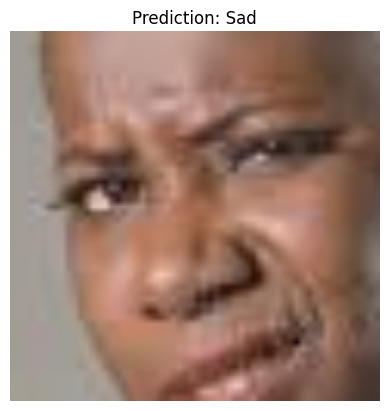

In [98]:
pred_and_plot( "D:/sem 8/CI project/download (1).jpg" , Emotion_Classes) # with ResNet50V2

above picture is of a disgest catagory but our model predicted this as sad

In [101]:
CNN_Model.save("CNN_Model.h5")

ResNet50V2_Model.save("ResNet50V2_Model.h5")